In [1]:

import json
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, concatenate, Reshape,BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.regularizers import l2

### Data preprocess

In [2]:
# Load data
json_file_path = r"C:\Users\Malik Haider\Documents\NewHumCare\JSON_FALL\FALL_DS.json"
with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)



In [3]:
df = pd.DataFrame(data)
print(len(df.columns[:-1]))

6


In [4]:
df.head()

,PhoneAccelerometer_train,PhoneGyroscope_train,PhoneMagnetometer_train,WatchAccelerometer_train,WatchGyroscope_train,WatchMagnetometer_train,Y_train
0,"[0.48843205, 0.48843205, 0.48843205, 0.4908263...","[-0.01929479, -0.01929479, -0.02173825, -0.022...","[-30.599998, -30.42, -30.0, -29.76, -29.699999...","[9.92636, 9.868899, 9.742006, 9.6845455, 9.607...","[-0.3494149, -0.33475417, -0.31520647, -0.2932...","[-37.44, -37.92, -37.8, -39.12, -39.12, -38.7,...",2
1,"[0.6751855, 0.67279124, 0.6656084, 0.6560313, ...","[-0.0058557545, -0.005244889, -0.0064666197, -...","[-30.599998, -30.42, -30.599998, -30.48, -30.3...","[9.497798, 9.490616, 9.533711, 9.548077, 9.485...","[0.004886922, 0.0036651916, -0.0012217305, -0....","[-38.46, -38.579998, -38.219997, -38.52, -38.2...",2
2,"[2.8252442, 2.6121538, 2.1021733, 1.6664152, 1...","[-0.9960683, -1.0143943, -1.0260007, -1.065096...","[-28.8, -28.439999, -28.439999, -28.439999, -2...","[6.667852, 7.055712, 6.8522053, 6.43322, 6.366...","[1.690875, 1.9315559, 1.8997909, 1.709201, 0.9...","[-38.7, -38.879997, -39.239998, -39.239998, -3...",2
3,"[3.3088877, 3.4214187, 3.5962007, 3.5746522, 3...","[-1.1078566, -1.0473809, -0.98446184, -0.91909...","[-29.34, -28.68, -29.22, -28.98, -29.039999, -...","[8.50181, 7.4842744, 6.9407907, 6.9479733, 7.1...","[-2.2333233, -1.6224581, -1.1716396, -0.714712...","[-41.64, -41.34, -41.16, -40.5, -40.44, -40.14...",2
4,"[1.1396748, 1.1564348, 1.1612233, 1.1803775, 1...","[0.035683084, 0.033850487, 0.033850487, 0.0350...","[-33.0, -33.12, -33.42, -33.36, -33.48, -33.36...","[10.335769, 10.223241, 10.146626, 10.086772, 9...","[0.67073005, 0.6560693, 0.6377433, 0.6401868, ...","[-38.1, -38.04, -38.1, -37.92, -37.559998, -37...",2


In [5]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, random_state=42,test_size=0.2)

In [6]:
# Define other constants
feature_dimension = 1  # Since each column contains a 1D list
num_classes = 8  # Number of unique values in Y_train 61,55,6
num_features = 6  # Number of features in DataFrame
flatten_size = 200  # Reduced number of neurons

# Prepare data and train the model
y_train = np.array(train_set['Y_train'])
X_features = [np.array(train_set[column].to_list()) for column in train_set.columns[:-1]]

In [7]:
len(df)

2971

In [9]:
# Define a function to calculate the minimum length of non-empty lists in each column
def min_list_length(column):
    non_empty_lists = [x for x in column if isinstance(x, list) and len(x) > 0]
    return min([len(x) for x in non_empty_lists]) if non_empty_lists else 0

# Use the apply function to apply the custom function to each column
min_lengths = df.apply(min_list_length)

# min_lengths will contain the minimum lengths of non-empty lists in each column
print(min_lengths)

PhoneAccelerometer_train    1200
PhoneGyroscope_train        5880
PhoneMagnetometer_train     1200
WatchAccelerometer_train    1176
WatchGyroscope_train        1176
WatchMagnetometer_train     1176
Y_train                        0
dtype: int64


In [25]:
y_train = np.array(train_set['Y_train'])
values = np.unique(y_train)
print(values)

[0 1 2 3 4 5 6 7]


In [27]:
# Prepare data for testing
y_test = np.array(test_set['Y_train'])
#X_features1 = [np.array(test_set[column].to_list()) for column in test_set.columns[:-1]]
X_features1 = [np.stack(test_set[column].to_list(), axis=0).reshape(len(test_set), -1, feature_dimension) for column in test_set.columns[:-1]]

## Creating and Training Model

In [30]:
# Create the input layers for each feature
input_layers = []

# Create separate CNNs for each feature
cnn_outputs = []
for feature in train_set.columns[:-1]:
    length = df[feature].apply(len)[0]
    input_layer = Input(shape=(length, 1))
    input_layers.append(input_layer)
    cnn = Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
    cnn = MaxPooling1D(pool_size=4)(cnn)
    cnn = Conv1D(16, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01))(cnn)
    cnn = MaxPooling1D(pool_size=4)(cnn)
    cnn = Flatten()(cnn)
    cnn = Dense(flatten_size, activation='relu', kernel_regularizer=l2(0.01))(cnn)
    
    # Add dropout after the Dense layer
    cnn = Dropout(0.3)(cnn)  # Adjust the dropout rate as needed
    
    cnn_outputs.append(cnn)

# Concatenate the CNN outputs
merged_cnn = concatenate(cnn_outputs)
merged_cnn = BatchNormalization()(merged_cnn)
# Reshape the concatenated CNN outputs to match the LSTM input shape
reshaped_cnn = Reshape((num_features, -1))(merged_cnn)

# LSTM 
lstm = LSTM(32, return_sequences=True)(reshaped_cnn)
lstm = LSTM(16)(lstm)


# Fully connected layers
dense1 = Dense(32, activation='relu')(lstm)
output = Dense(num_classes, activation='softmax')(dense1)

# Training parameters
number_of_epoch = 200
batch_size = 32 

# Create the combined model
model = Model(inputs=input_layers, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_features, y_train, epochs=number_of_epoch, batch_size=batch_size, validation_data=(X_features1, y_test))

Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 224ms/step - accuracy: 0.3344 - loss: 13.6516 - val_accuracy: 0.6034 - val_loss: 2.5130
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.6779 - loss: 2.0065 - val_accuracy: 0.6891 - val_loss: 1.5798
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 0.7357 - loss: 1.3740 - val_accuracy: 0.6437 - val_loss: 1.5650
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.7586 - loss: 1.1721 - val_accuracy: 0.6588 - val_loss: 1.2749
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.7801 - loss: 1.0619 - val_accuracy: 0.6773 - val_loss: 1.2372
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.7944 - loss: 0.9611 - val_accuracy: 0.6874 - val_loss: 1.1727
Epoch 7/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.7905 - loss: 0.9218 - val_accuracy: 0.7513 - val_loss: 1.0892
Epoch 8/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.8096 - loss: 0.9075 -

KeyboardInterrupt: 

In [58]:
model.save(r'C:\Users\Malik Haider\Downloads\Model_Results\trainAtomicdata1DFall.keras')

In [48]:
model = tf.keras.models.load_model(r'C:\Users\Malik Haider\Documents\NewHumCare\Model_Results_200_ep_Maam_auto\model.keras')

In [50]:
# Prepare data for testing
y_test = np.array(test_set['Y_train'])

X_features1 = [np.array(test_set[column].to_list()) for column in test_set.columns[:-1]]

In [52]:
# Get unique classes and print count

u,c=np.unique(test_set['Y_train'], return_counts=True)
print(u)
print(c)

[0 1 2 3 4 5 6 7]
[81 73 66 73 75 77 74 76]


In [54]:
# Make predictions
predictions = model.predict(X_features1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step


In [55]:
# Interpret the predictions
predicted_classes = tf.argmax(predictions,axis=1)

In [58]:
#calculate accuracy
accuracy = tf.reduce_mean(tf.cast(predicted_classes == y_test,tf.float32))

In [60]:
print("Accuracy:",accuracy.numpy())

Accuracy: 0.8235294


In [62]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_test, predicted_classes, average='macro')
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_test, predicted_classes, average='macro')
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_test, predicted_classes, average='macro')
print(f'F1-Score: {f1}')

Confusion Matrix:
[[55  3 22  0  0  0  0  1]
 [ 2 65  0  0  5  0  1  0]
 [15  0 49  0  0  0  1  1]
 [ 0  0  0 55  4 12  2  0]
 [ 1  3  0  6 63  2  0  0]
 [ 0  0  0 15  0 61  1  0]
 [ 1  1  1  2  0  1 68  0]
 [ 0  1  1  0  0  0  0 74]]
Accuracy: 0.8235294117647058
Precision: 0.8241047403470799
Recall: 0.8237603907743298
F1-Score: 0.8233729909106798


In [64]:
for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = conf_matrix[:, i].sum() - TP
    FN = conf_matrix[i, :].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / conf_matrix.sum()

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall:    {recall:.2f}")
    print(f"  F1-score:  {f1:.2f}")
    print(f"  Accuracy:  {accuracy:.2f}")
    print()


Class 0:
  Precision: 0.74
  Recall:    0.68
  F1-score:  0.71
  Accuracy:  0.92

Class 1:
  Precision: 0.89
  Recall:    0.89
  F1-score:  0.89
  Accuracy:  0.97

Class 2:
  Precision: 0.67
  Recall:    0.74
  F1-score:  0.71
  Accuracy:  0.93

Class 3:
  Precision: 0.71
  Recall:    0.75
  F1-score:  0.73
  Accuracy:  0.93

Class 4:
  Precision: 0.88
  Recall:    0.84
  F1-score:  0.86
  Accuracy:  0.96

Class 5:
  Precision: 0.80
  Recall:    0.79
  F1-score:  0.80
  Accuracy:  0.95

Class 6:
  Precision: 0.93
  Recall:    0.92
  F1-score:  0.93
  Accuracy:  0.98

Class 7:
  Precision: 0.97
  Recall:    0.97
  F1-score:  0.97
  Accuracy:  0.99



In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig(r'C:\Users\Malik Haider\Downloads\Model_Results\TL-Loss-3-modalities.jpg')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.savefig(r'C:\Users\Malik Haider\Downloads\Model_Results\TL-accuracy-modalities.jpg')
plt.show()

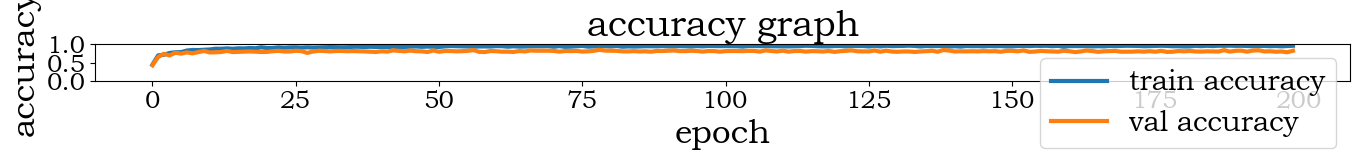

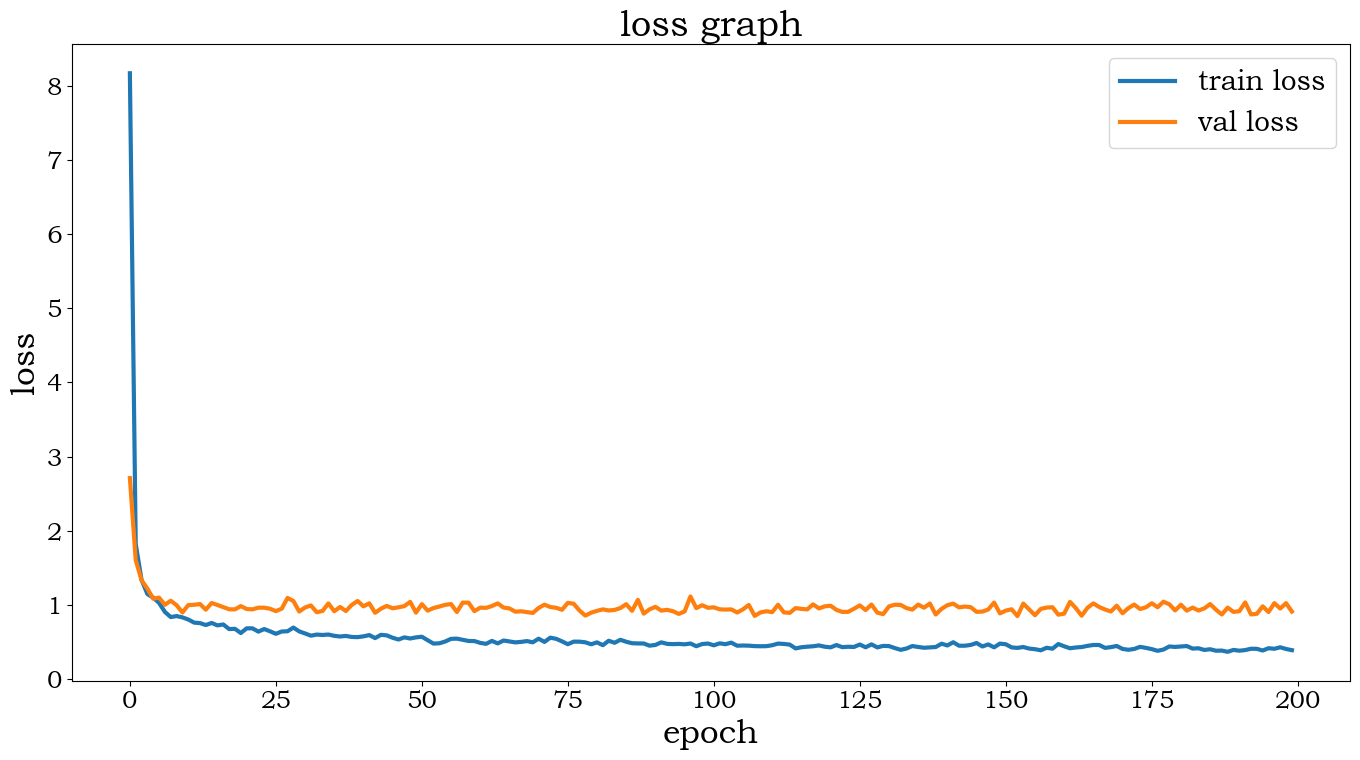

In [84]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Load Bookman Old Style Light
font_path = r"C:\Users\Malik Haider\AppData\Local\Microsoft\Windows\Fonts\BOOKOS.TTF"  # Update if needed
bookman_font = fm.FontProperties(fname=font_path)

# Set global plot styles
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 26,
    'axes.labelsize': 24,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 20,
    'lines.linewidth': 3,
    'font.family': bookman_font.get_name()
})

# --- Accuracy Plot ---
plt.figure(figsize=(14, 2))
plt.plot(hist['accuracy'], label='train accuracy')
plt.plot(hist['val_accuracy'], label='val accuracy')
plt.title('accuracy graph')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.yticks(np.arange(0.0, 1.01, 0.5))
plt.legend()
plt.tight_layout()
plt.savefig(r'C:\Users\Malik Haider\Downloads\Model_Results\dropout_accuracy_highres.jpg', dpi=600)
plt.show()

# --- Loss Plot ---
plt.figure(figsize=(14, 8))
plt.plot(hist['loss'], label='train loss')
plt.plot(hist['val_loss'], label='val loss')
plt.title('loss graph')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.tight_layout()
plt.savefig(r'C:\Users\Malik Haider\Downloads\Model_Results\dropout_loss_highres.jpg', dpi=600)
plt.show()

In [66]:
def normalize_conf_matrix_to_100(conf_matrix):
    norm_matrix = []
    for row in conf_matrix:
        total = row.sum()
        if total == 0:
            norm_matrix.append([0]*len(row))
            continue

        # Raw float percentages
        raw_percents = row / total * 100.0
        floored = np.floor(raw_percents).astype(int)
        diff = 100 - floored.sum()

        # Add the remaining percentage points to the highest residuals
        residuals = raw_percents - floored
        for i in np.argsort(residuals)[-diff:]:
            floored[i] += 1

        norm_matrix.append(floored)

    return np.array(norm_matrix)


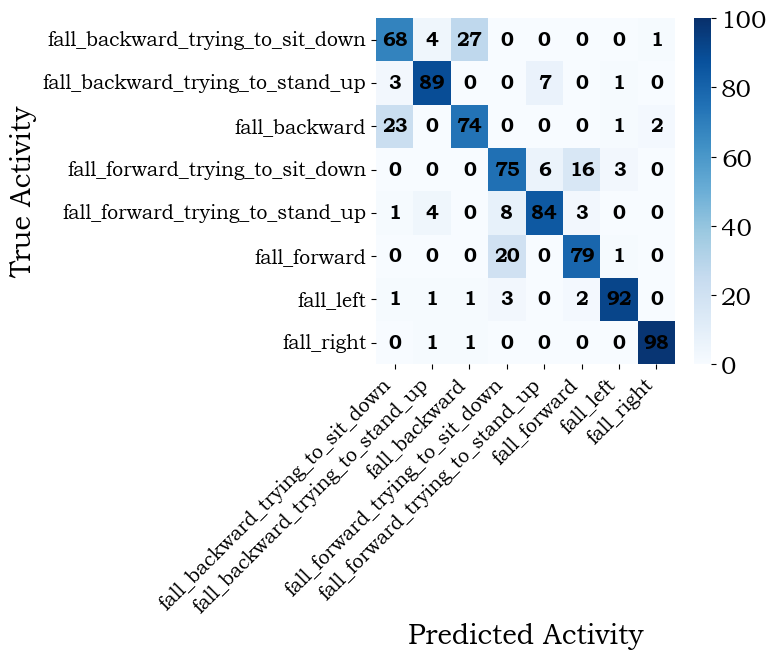

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.font_manager as fm

# Load Bookman Old Style font
font_path = r"C:\Users\Malik Haider\AppData\Local\Microsoft\Windows\Fonts\BOOKOS.TTF"
try:
    bookman_font = fm.FontProperties(fname=font_path)
except:
    bookman_font = None

# Define fall-related activity labels
activity_names = [
    'fall_backward_trying_to_sit_down',
    'fall_backward_trying_to_stand_up',
    'fall_backward',
    'fall_forward_trying_to_sit_down',
    'fall_forward_trying_to_stand_up',
    'fall_forward',
    'fall_left',
    'fall_right'
]

# Normalize confusion matrix to percentage and convert for display
# conf_matrix_percent = np.round(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100).astype(int)
conf_matrix_percent = normalize_conf_matrix_to_100(conf_matrix)
conf_matrix_count = conf_matrix.astype(int)

# Plot heatmap
plt.figure(figsize=(8, 7))
ax = sns.heatmap(
    conf_matrix_percent,
    # annot=conf_matrix_count,  # Show raw instance counts in each cell
    annot=True,
    fmt='d',                  # Display as integers
    cmap='Blues',
    xticklabels=activity_names,
    yticklabels=activity_names,
    cbar=True,
    vmin=0, vmax=100,
    annot_kws={"size": 14, "color": "black", "weight": "bold"}
)

# Apply font styling
if bookman_font:
    # plt.title(
    #     'Confusion Matrix for Fall Activity Classification\n(Color: % Accuracy, Values: Instances)',
    #     fontproperties=bookman_font, fontsize=24
    # )
    plt.xlabel('Predicted Activity', fontproperties=bookman_font, fontsize=20)
    plt.ylabel('True Activity', fontproperties=bookman_font, fontsize=20)
    ax.set_xticklabels(activity_names, fontproperties=bookman_font, fontsize=14, rotation=45, ha='right')
    ax.set_yticklabels(activity_names, fontproperties=bookman_font, fontsize=14, rotation=0)
else:
    # plt.title(
    #     'Confusion Matrix for Fall Activity Classification\n(Color: % Accuracy, Values: Instances)',
    #     fontsize=24, fontname='serif'
    # )
    plt.xlabel('Predicted Activity', fontsize=20, fontname='serif')
    plt.ylabel('True Activity', fontsize=20, fontname='serif')
    ax.set_xticklabels(activity_names, fontsize=14, rotation=45, ha='right')
    ax.set_yticklabels(activity_names, fontsize=14, rotation=0)

# Layout and save
plt.tight_layout()
plt.savefig(r'C:\Users\Malik Haider\Downloads\Model_Results\Fall_Confusion_Matrix_HighRes.jpg', dpi=600)
plt.show()


### Model and History Saving

In [32]:
import pickle

class_map = {
    0: 'fall_backward_trying_to_sit_down',
    1: 'fall_backward_trying_to_stand_up',
    2: 'fall_backward',
    3: 'fall_forward_trying_to_sit_down',
    4: 'fall_forward_trying_to_stand_up',
    5: 'fall_forward',
    6: 'fall_left',
    7: 'fall_right'
}


model.save(r'C:\Users\Malik Haider\Documents\NewHumCare\Model_Results\model.keras')
with open(r"C:\Users\Malik Haider\Documents\NewHumCare\Model_Results\history.json","w") as f: json.dump(history.history,f)
pickle.dump(class_map, open(r"C:\Users\Malik Haider\Documents\NewHumCare\Model_Results\class_map.pkl","wb"))
np.save(r"C:\Users\Malik Haider\Documents\NewHumCare\Model_Results\cm.npy",conf_matrix)
pd.DataFrame(report).T.to_csv(r"C:\Users\Malik Haider\Documents\NewHumCare\Model_Results\report.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Malik Haider\\Documents\\NewHumCare\\Model_Results\\model.keras'

In [44]:
model = load_model(r'C:\Users\Malik Haider\Documents\NewHumCare\Model_Results_200_ep_Maam_auto\trainAtomicData1DFall.keras')
hist  = json.load(open(r"C:\Users\Malik Haider\Documents\NewHumCare\Model_Results_200_ep_Maam_auto\history.json"))
cm    = np.load(r"C:\Users\Malik Haider\Documents\NewHumCare\Model_Results_200_ep_Maam_auto\class_map.pkl")
# report_df = pd.read_csv(r"C:\Users\Malik Haider\Documents\NewHumCare\Model_Results\report.csv", index_col=0)
# re‐plot from hist, display cm / report_df…


NameError: name 'load_model' is not defined